### 2.1 keras中的one-hot与word-embedding
本节最后给出一个电影评论的的例子.   
第四点中, 该例已经自动将评论句子转换为单词index的列表  
第五点中, 介绍从最原始的文本数据,到转换成word index, 再使用预先训练好的词嵌入训练网络的全部过程

#### 一. 文本处理
1. 神经网络并不能像人类一样理解语言, 是模式识别在word上的应用
2. 神经网络不能处理原始文本, 只能处理数值型tensor 
3. 文本处理的一般流程  
  语句 -> tockens (word) -> word vector  
  <img src="img/testdata1.png" width="45%" height="45%"/>
4. n-grams  
 n-grams是从语句中抽取出来的所有连续的n个单词  
  eg: `The cat sat on the mat` 对应的`2-grams` :   
  { "The","The\quad cat","cat","cat\quad sat","sat","sat\quad on","on","on\quad the","the","the\quad mat","mat" \right\}   
   对应的`3-grams` :  
   {"The", "The cat", "cat", "cat sat", "The cat sat",
"sat", "sat on", "on", "cat sat on", "on the", "the",
"sat on the", "the mat", "mat", "on the mat"}

#### 二. 单词或字符的one-hot编码
1. 词典表  
 one-hot编码需要用到词典表DIctionary, 在keras中, 词典表需要学习而来. 通过统计语料库中所有语句中出现的单词, 并给单词赋予index来生成词典表.  
 所以, keras的词典表形式为`{'word':index}`
2. 对语句编码  
 `keras.preprocessing.text.Tokenizer`可以指定只对最常用的单词进行编码. 

In [23]:
import keras 
sentences = ['The cat sat on the mat.', 'The dog ate my homework.']
# 1. 声明keras的tokenizer, 只对学习到的词典表前1000个单词编码
tokenizer = keras.preprocessing.text.Tokenizer(num_words=1000)
# 2. keras根据输入的语句库,生成词典, 词典中包括语料库中所有的单词, 并为每个单词编号
tokenizer.fit_on_texts(sentences)

sequences = tokenizer.texts_to_sequences(sentences)
print 'sequences: ',sequences

# 3. keras的one-hot编码
one_hot_results = tokenizer.texts_to_matrix(sentences,mode='binary')
print 'one_hot_results.shape = ',one_hot_results.shape
print 'one_hot_results :\n',one_hot_results[:,:11]

# 4. keras学习到的词典表
print 'dictionary : ',tokenizer.word_index

sequences:  [[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]
one_hot_results.shape =  (2, 1000)
one_hot_results :
[[0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.]]
dictionary :  {'on': 4, 'ate': 7, 'mat': 5, 'dog': 6, 'cat': 2, 'the': 1, 'my': 8, 'homework': 9, 'sat': 3}


#### 三. one-hot hash
1. one-hot hash可以把单词通过计算hash值, 来确定单词所属的index.  
 因此one-hot hash的词典表不用在语料库上学习.  所以, 也可将one-hot hash编码应用于在线学习
2. 由于hash计算单词的index, 可能会导致不同的单词映射到同一个index, 此时, 后续算法无法感知到这两个单词的不同
3. one-hot hash直接返回编码后的单词序号序列

In [28]:
sentence1 = 'The cat sat on the mat.'
# n : 指定散列空间维度
keras.preprocessing.text.hashing_trick(sentence1,n=1000,lower=True)

[87, 75, 365, 85, 87, 886]

#### 四. word-embedding
1. word-embedding是一个稠密单词向量. 对比one-hot产生的词向量是高纬度的,稀疏的, 二维编码(0/1)的  
 keras通过embedding层学习/处理词嵌入. Embedding的基本参数有3个  
   1. input_dim : 词汇表大小
   2. output_dim : 词向量维度
   3. input_length : 句子中单词个数, 用于计算与Embedding层连接的Flatten层的尺寸
1. Embedding层的作用  
 Embedding层词典的整数word index映射成稠密矩阵的层
2. 输入 : 2D张量 (samples,sequences_length)  
 因为要组成张量送给Embedding层, 所以要求语料库中语句长度一致. 短句要在结尾补0(0号index), 长句要截断结尾的单词
3. 输出 : 3D张量 (samples,sequences_length,embedding_dimensionality)  
 输出的3D张量, 可被RNN层/1D的卷基层处理
4. Embedding词嵌入处理逻辑
 Embedding层对单词权重的初始化是随机的, 通过反向传播, 不断改进词嵌入矩阵以适应当前处理的问题.
5. 以下例子, 数据集来自IMDB  
  1. 我们首先使用Embedding层初始化词嵌入, 输出3D张量  
  2. 然后将每个句子的2D词嵌入拉平成1D向量作为神经网络输入数据进行训练
可以看到, 验证集上准确率达到76%, 实际上这个表现还可以, 因为我们只考虑了评论中前20个单词

In [15]:
##########################[  1. 裁剪评论为20个单词的语句  ]###############################
from keras.datasets import imdb
from keras import preprocessing

# number of words consider as features
max_features = 10000
# sentence length
maxlen = 20

# 因为每个评论内容长度不同, 所以x_train的结构是一个长度25,000的向量, 向量中每个元素是不等长度的List[Int]
(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=max_features)
# 裁剪sentences, 全部长度20个单词
x_train = preprocessing.sequence.pad_sequences(x_train,maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test,maxlen=maxlen)

###################################[  2. 构建网络  ]#######################################
######### Embedding(words,dimension,word_number_in_sentences) -> Flatten -> Dense(sigmiod)#########
from keras.models import Sequential
from keras.layers import Flatten,Dense,Embedding

model = Sequential()
# 词嵌入矩阵, 10,000行8列. 每个句子被平铺成20*8的向量
model.add(Embedding(10000,8,input_length=maxlen))
# 平铺Embedding输出的3D矩阵为2D矩阵 (samples,maxlen*8)
model.add(Flatten())
# 二分类输出
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
print model.summary()
history = model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
None
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 225us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 3s 135us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 2s 124us/step 

In [19]:
# 再次查看送给Embedding的数据为句子中每个词的编号
print x_train[:5]

[[  65   16   38 1334   88   12   16  283    5   16 4472  113  103   32
    15   16 5345   19  178   32]
 [  23    4 1690   15   16    4 1355    5   28    6   52  154  462   33
    89   78  285   16  145   95]
 [1352   13  191   79  638   89    2   14    9    8  106  607  624   35
   534    6  227    7  129  113]
 [   7 2804    5    4  559  154  888    7  726   50   26   49 7008   15
   566   30  579   21   64 2574]
 [  15  595   13  784   25 3171   18  165  170  143   19   14    5 7224
     6  226  251    7   61  113]]


#### 五. 使用预先训练好的word-embedding
1. . 下载原始文本数据的imdb数据集 [http://mng.bz/0tIo](http://mng.bz/0tIo)
 该例子介绍从最原始的文本数据开始训练文本分类  
 

In [97]:
# 1. 准备imdb原始文本数据的标签
import os

imdb_dir = '/home/lj/data/Deelearning_with_python/aclImdb'
train_dir = os.path.join(imdb_dir,'train')

labels = []
texts = []

for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name,fname),'r') as f:
                texts.append(f.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [98]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen=100                          # sentence长度
train_samples = 200              # 训练集语句数
validation_samples = 10000  # 验证集10000个
max_words = 10000              # 只考虑词典前10000号的单词

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)   
sequences = tokenizer.texts_to_sequences(texts)# 将句子分成词后,找到词对应的index

# word_index 是一个dict, 结构为{word name : index number}
word_index = tokenizer.word_index  
print 'found %s unique tokens' % len(word_index)
print word_index.items()[:3]  # word_index前3个kv

found 88584 unique tokens
[('fawn', 38366), ('tsukino', 82839), ('nunnery', 59104)]


In [99]:
# 切分句子为等长的, 组成2d-tensor
data = pad_sequences(sequences,maxlen=maxlen)
labels = np.array(labels)
print 'shape of data tensor: ', data.shape
print 'shape of label tensor: ',labels.shape

shape of data tensor:  (25000, 100)
shape of label tensor:  (25000,)


In [100]:
len(texts)

25000

In [101]:
# shuffle data : 因为初始数据是有序的, 正例和负例分开放在不同文件夹下
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# 划分训练集,测试集
x_train = data[:train_samples,:]
y_train = labels[:train_samples]
x_val = data[train_samples:train_samples+validation_samples,:]
y_val = labels[train_samples:train_samples+validation_samples]

x_train[1]

array([ 142,   96,  187,   33,  869,    5,   25,    3,  598,    2, 2888,
         21,   63,   28, 3136,   21,   57,   28, 3136,    2,  104,   18,
         61,  286,    2,    3, 7437,   12, 1287,  237,    3,  909, 1093,
       4840,  170,   13, 1147,   30,    1,  127, 9530, 2471,   93,   96,
         73,   93,   96,    2,   93,   96, 3701,    5,   27,  280,   56,
        211, 8246, 1001,    3, 1460, 4504,   12,   13,    3, 1678,  586,
          4, 1742,  483,  266,    5, 8435,    1,  169,  959,   36,    1,
         83,   28,   12,   40,  158,  154,    9,   13,   96,   73,  117,
          1,  347,    2,   21,   96,  160,   10,  162,  418,  803,   41,
       9530], dtype=int32)

In [102]:
# 解析下载的glove word embedding文件
glove_dir= '/home/lj/data/word_embedding/glove.6B'
embedding_index = {}

# 先来看一下下载的embedding文件结构
tmp = open(os.path.join(glove_dir,'glove.6B.100d.txt'),'r') 
print tmp.readline()
tmp.close()

# 正式处理word embedding文件, 生成{word name : embedding vector}结构
with open(os.path.join(glove_dir,'glove.6B.100d.txt'),'r') as f :
    for line in f : 
        # embedding文件每行, 第一个为单词名, 后面的是单词词向量系数
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:],dtype='float32')
        embedding_index[word] = coefs
print 'found %s word vectors' % len(embedding_index)

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

found 400000 word vectors


In [103]:
# 准备GloVe词嵌入矩阵
# embedding文件中单词出现的序号, 就是单词在词典中的index
embedding_dim = 100
embedding_matrix = np.zeros((max_words,embedding_dim))
for word,i in word_index.items():
    if i < max_words : 
        embedding_vactor = embedding_index.get(word)
        if embedding_vactor is not None : 
            embedding_matrix[i] = embedding_vactor

# 词嵌入矩阵的0号不能记录实际存在的词, 0号只是占位符
embedding_matrix[1:2]

array([[-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
         0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
         0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
        -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
         0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
        -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
        -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
         0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
        -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
         0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
        -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
        -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
        -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
        -0.19358   , -0.074575  ,  0.23353   , -0.0

In [104]:
# 构建神经网络
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense

model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [105]:
# 加载GloVe词嵌入到神经网络中
#   Embedding层u偶一个统一的系数矩阵 : 2D张量, 每行为词的词嵌入系数
print embedding_matrix.shape
model.set_weights([embedding_matrix])
model.layers[0].trainable = False  # 冻结Embedding层

(10000, 100)


In [106]:
# 编译网络
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_val,y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 1.7660 - acc: 0.5150 - val_loss: 0.7548 - val_acc: 0.4947
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6055 - acc: 0.6000 - val_loss: 0.9504 - val_acc: 0.4947
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5923 - acc: 0.6500 - val_loss: 0.7046 - val_acc: 0.4956
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5619 - acc: 0.6700 - val_loss: 0.7101 - val_acc: 0.4985
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4702 - acc: 0.7050 - val_loss: 0.9428 - val_acc: 0.4947
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4394 - acc: 0.7700 - val_loss: 0.7555 - val_acc: 0.4961
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3931 - acc: 0.7550 - val_loss: 0.9180 - val_acc: 0.4948
Epoch 8/10
200/200 [========

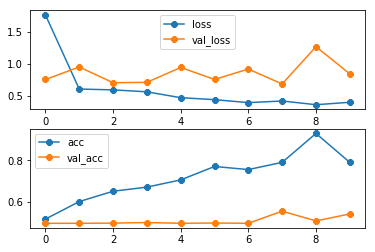

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
f,axes = plt.subplots(2,1)
pd.DataFrame({"loss":loss,'val_loss':val_loss}).plot(style='8-',ax=axes[0])
pd.DataFrame({"acc":acc,'val_acc':val_acc}).plot(style='8-',ax=axes[1])

[注] : 
- 观察发现, 模型很快过拟合. 这也不奇怪, 因为我们只用了很少的语句进行训练, 却用了很多语句进行验证. 因此网络的表现, 只取决于最先随机选择的200个训练样本.而且上面的例子, 我们加载了下载的词嵌入矩阵.   
- 在训练样本足够多的情况下, 可以自行学习词嵌入矩阵, 此时得到的是解决特定问题的词嵌入矩阵. 作为练习, 我们不加载词嵌入矩阵看看表现  
 会发现不如加载词嵌入矩阵时的表现, 说明别人训练好的词嵌入矩阵还是很有用的, 当然, 改变训练集的大小, 情况会有所不同

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6956 - acc: 0.5000 - val_loss: 0.6922 - val_acc: 0.5172
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.480

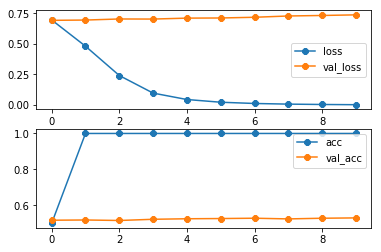

In [108]:
model2 = Sequential()
model2.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model2.add(Flatten())
model2.add(Dense(32,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))
print model2.summary()

model2.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history2 = model2.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_val,y_val))

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
f,axes = plt.subplots(2,1)
pd.DataFrame({"loss":loss,'val_loss':val_loss}).plot(style='8-',ax=axes[0])
pd.DataFrame({"acc":acc,'val_acc':val_acc}).plot(style='8-',ax=axes[1])

最后, 来看看模型在测试集上的表现

In [112]:
# 在测试集上分词
test_dir = os.path.join(imdb_dir,'test')
labels = []
texts = []
for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name,fname),'r') as f:
                texts.append(f.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)

x_test = pad_sequences(sequences,maxlen=maxlen)
y_test = np.array(labels)

model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test,y_test)

25000/25000 [==============================] - 1s 48us/step


[0.8399702775764465, 0.53832]